## This notebook starts from existing azimuth and altitude maps of mouse visual cortex and calculates the visual sign map and segments the sign map into several patches (putative visual areas). 

<br><br>

Currently the [retinotopic_mapping package](https://github.com/zhuangjun1981/retinotopic_mapping) does not include the analysis code which generates altitude and azimuth maps from raw acquired image series and visual stimulation log. This is because 
the various hardware and software people use to display visual stimuli and to acquire images. There is no universal way to preprocess data.

<br><br>

The procedures used in [Zhuang et al., 2017](https://elifesciences.org/articles/18372) to generate altitude and azimuth maps are as follows:

1.	For stimulus sweep in each direction (bottom-up, top-down, nasal-temporal and temporal-nasal), the raw acquired movies were averaged across all presentations. It generated four averaged movies for each sweep direction. The duration of each movie equals the duration of one cycle of corresponding sweep (one sweep across the screen plus inter-sweep gray period). 
2.	For each averaged movie, the mean activity over the pre-sweep gray period was subtracted to generate delta F movies. Delta F movies should look like video 1 in Zhuang et al., 2017, Elife, 6:e18372. There will be four delta F movies, each corresponding to one sweep direction.
3.	Perform fft of each delta F movie along the time dimension and extract the phase of the first harmonic frequency component. Because these are averaged movies, the first harmonic frequency should be the frequency of the visual stimulus sweep. There will be four different phase maps, each corresponding to one sweep direction. Power maps at this particular frequency can be also extracted at this step.
4.	The phase represents the timing within the cycle, by analyzing the visual stimulus log (this part depends on how visual stimulus was displayed which may vary significantly from lab to lab), the phase can be converted to the location of the sweeping checkerboard on screen. After the conversion, four location maps will be generated, each corresponding to a sweep direction.
5.	The location maps of bottom-up and top-down directions were averaged to generate the altitude map, and location maps of nasal-temporal and temporal-nasal directions were averaged to generate the azimuth map.  

<br><br>
In python the code of phase and power extracting looks like these (assuming the first dimension of the movie is time):  
<br><br>
```
import numpy as np

spectrumMovie = np.fft.fft(movie, axis=0)

#generate power movie
powerMovie = (np.abs(spectrumMovie) * 2.) / np.size(movie, 0)
powerMap = np.abs(powerMovie[1,:,:])

#generate phase movie
phaseMovie = np.angle(spectrumMovie)
phaseMap = -1 * phaseMovie[1,:,:]
phaseMap = phaseMap % (2 * np.pi)
```

In [413]:
import os
import glob
import cv2
import re

import numpy as np
import scipy.stats as spstats

import retinotopic_mapping
import retinotopic_mapping.tools.FileTools as ft
import retinotopic_mapping.tools.PlottingTools as pt

import retinotopic_mapping.RetinotopicMapping as rm
import skimage.external.tifffile as tf
import matplotlib.pyplot as plt

%matplotlib inline

In [414]:
reload(ft)

<module 'retinotopic_mapping.tools.FileTools' from '/home/julianarhee/anaconda2/envs/retinotopic_mapping/lib/python2.7/site-packages/retinotopic_mapping-2.9.4-py2.7.egg/retinotopic_mapping/tools/FileTools.pyc'>

In [415]:
import cv2
from scipy import misc,interpolate,stats,signal
from matplotlib.colors import LinearSegmentedColormap


def smooth_array(inputArray, fwhm, phaseArray=False):
    szList=np.array([None,None,None,11,None,21,None,27,None,31,None,37,None,43,None,49,None,53,None,59,None,55,None,69,None,79,None,89,None,99])
    sigmaList=np.array([None,None,None,.9,None,1.7,None,2.6,None,3.4,None,4.3,None,5.1,None,6.4,None,6.8,None,7.6,None,8.5,None,9.4,None,10.3,None,11.2,None,12])
    sigma=sigmaList[fwhm]
    sz=szList[fwhm]
    #print(sigma, sz)
    if phaseArray:
        outputArray = smooth_phase_array(inputArray,sigma,sz)
    else:
        outputArray=cv2.GaussianBlur(inputArray, (sz,sz), sigma, sigma)
        
    return outputArray
        
def smooth_phase_array(theta,sigma,sz):
    #build 2D Gaussian Kernel
    kernelX = cv2.getGaussianKernel(sz, sigma); 
    kernelY = cv2.getGaussianKernel(sz, sigma); 
    kernelXY = kernelX * kernelY.transpose(); 
    kernelXY_norm=np.true_divide(kernelXY,np.max(kernelXY.flatten()))
    
    #get x and y components of unit-length vector
    componentX=np.cos(theta)
    componentY=np.sin(theta)
    
    #convolce
    componentX_smooth=signal.convolve2d(componentX,kernelXY_norm,mode='same',boundary='symm')
    componentY_smooth=signal.convolve2d(componentY,kernelXY_norm,mode='same',boundary='symm')

    theta_smooth=np.arctan2(componentY_smooth,componentX_smooth)
    return theta_smooth


def shift_map(phase_az):
    phaseC_az=np.copy(phase_az)
    minv = phase_az[~np.isnan(phase_az)].min()
    maxv = phase_az[~np.isnan(phase_az)].max()
    #print(minv, maxv)
    if (minv < 0): # and maxv > 0):
        phaseC_az[phase_az<0]=-phase_az[phase_az<0]
        #print("flipped neg", phaseC_az.min(), phaseC_az.max())
        phaseC_az[phase_az>0]=(2*np.pi)-phase_az[phase_az>0]
        #print("flipped pos", phaseC_az.min(), phaseC_az.max())

    else:
        print("Already non-negative (min/max: %.2f, %.2f)" % (phaseC_az.min(), phaseC_az.max()))
    return phaseC_az


In [4]:
def label_figure(fig, data_id):
    fig.text(0, .97, data_id)


In [5]:

def convert_range(oldval, newmin=None, newmax=None, oldmax=None, oldmin=None):
    oldrange = (oldmax - oldmin)
    newrange = (newmax - newmin)
    newval = (((oldval - oldmin) * newrange) / oldrange) + newmin
    return newval

In [6]:
# move to package example folder 

package_folder = retinotopic_mapping.__path__
example_folder = os.path.join(package_folder[0], 'examples', 'signmap_analysis')
os.chdir(example_folder)

# Reading example vasculature image

In [7]:
# Base dirs
rootdir = '/n/coxfs01/2p-data'
# surface_basedir = '/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant'
analysis_basedir = '/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant'
analysis_subdirs = 'Analyses/timecourse/not_motion_corrected/excludeEdges_averageFrames_11_minusRollingMean'


In [209]:
# animalid = 'JC085'

animalid = 'JC117' #85' #'JC113' #'JC076'

# find sessions
found_sessions = np.unique([os.path.split(sesh)[-1].split('_')[0] \
                  for sesh in glob.glob(os.path.join(analysis_basedir, animalid, '2019*'))])
print('[%s]: Found %i sessions' % (animalid, len(found_sessions)))
for si, sesh in enumerate(found_sessions):
    print(si, sesh)
    

sesh = found_sessions[-1]
print(sesh)
surface_path = glob.glob(os.path.join(analysis_basedir, animalid, '%s*' % sesh, 'Surface', '*.png'))[0]
session = os.path.split(surface_path.split('/Surface')[0])[-1].split('_')[0]
data_id = '%s_%s' % (animalid, session)
print("DATA ID: %s" % data_id)

[JC117]: Found 1 sessions
(0, '20191022')
20191022
DATA ID: JC117_20191022


In [210]:
glob.glob(os.path.join(analysis_basedir, animalid, session, 'Surface', '*.png'))

['/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant/JC117/20191022/Surface/16bitSurf.png']

# Get vasculature image

In [416]:
surface_path = glob.glob(os.path.join(analysis_basedir, animalid, session, 'Surface', '*.png'))[0]
#surface_path = glob.glob(os.path.join(rootdir, animalid, 'macro_maps', '20*', '*urf*.png'))[0]

vasculature_map = cv2.imread(surface_path, -1)
widefield_d1, widefield_d2 = vasculature_map.shape
print("Surface image (%i, %i | %s)" % (widefield_d1, widefield_d2, vasculature_map.dtype))

Surface image (164, 218 | uint16)


In [424]:
signmapdir = '/n/coxfs01/julianarhee/aggregate-visual-areas/widefield-maps/signmaps'
basedir = os.path.join(signmapdir, 'retinotopic-mapper')
animaldir = 'JC117_20191022'
dst_dir = os.path.join(basedir, animaldir)
print(dst_dir)
os.path.exists(dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/widefield-maps/signmaps/retinotopic-mapper/JC117_20191022


True

(492, 656)


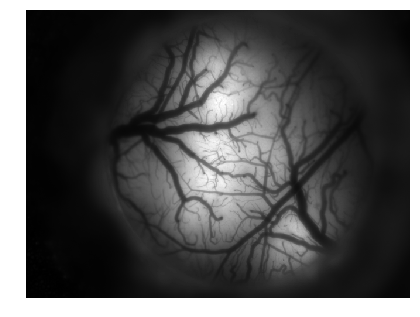

In [425]:
surface_path_hd = glob.glob(os.path.join(analysis_basedir, animalid, '%s*' % sesh, 'Surface', '*.png'))[0]
surface_hd = cv2.imread(surface_path_hd, -1)
print(surface_hd.shape)

#vasculature_map = tf.imread('example_vasculature_map.tif')
#vasculature_map = cv2.imread(surface_path, -1)
import pylab as pl
fig = pl.figure(figsize=(6,4), frameon=False)
ax = pl.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
im = ax.imshow(surface_hd, cmap='gray', interpolation='nearest')

pl.savefig(os.path.join(signmapdir, 'surface_hd__%s_%s.svg' % (animalid, sesh)))


In [426]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/widefield-maps/signmaps/retinotopic-mapper/JC117_20191022'

# Reading example retinotopic maps
cond1 = left
cond2 = right
cond3 = top
cond4 = bottom

In [427]:
mappaths = glob.glob(os.path.join(analysis_basedir, animalid, '%s*' % session, analysis_subdirs, 'phase_decoding', 'Files', '*.npz'))
for i, p in enumerate(mappaths):
    print(i, p)

condition_nums = {1: 'left',
                  2: 'right',
                  3: 'top',
                  4: 'bottom'}

condition_keys = {'azimuth': ['left', 'right'],
                  'altitude': ['top', 'bottom']}

mappath_d = {}
for mpath in mappaths:

    cond_name = re.findall(r'cond\d{1}_maps', mpath)[0]
    cond_num = int(re.findall(r'\d{1}', cond_name)[0])
    curr_cond = condition_nums[cond_num]
    
    mappath_d.update({curr_cond: mpath})


(0, '/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant/JC117/20191022/Analyses/timecourse/not_motion_corrected/excludeEdges_averageFrames_11_minusRollingMean/phase_decoding/Files/20191022_cond2_maps.npz')
(1, '/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant/JC117/20191022/Analyses/timecourse/not_motion_corrected/excludeEdges_averageFrames_11_minusRollingMean/phase_decoding/Files/20191022_cond3_maps.npz')


In [428]:
mappath_d

{'right': '/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant/JC117/20191022/Analyses/timecourse/not_motion_corrected/excludeEdges_averageFrames_11_minusRollingMean/phase_decoding/Files/20191022_cond2_maps.npz',
 'top': '/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant/JC117/20191022/Analyses/timecourse/not_motion_corrected/excludeEdges_averageFrames_11_minusRollingMean/phase_decoding/Files/20191022_cond3_maps.npz'}

In [429]:
def convert_to_absolute(cond_data, smooth_fwhm=7, smooth=True, power_metric='mag'):
    '''combine absolute, or shift single-cond map so that
    
    if AZI, 0=left, 2*np.pi=right 
    if ALT, 0=bottom 2*np.pi= top
    
    Use this to convert to linear coords, centered around 0.
    
    power_metric: can be 'mag' or 'magRatio' (for Map type saved in analyzed maps).
    
    '''
    vmin = 0
    vmax = 2*np.pi

    if len(cond_data.keys()) > 1:
        c1 = 'left' if 'left' in cond_data.keys() else 'top'
        c2 = 'right' if c1=='left' else 'bottom'
    
        # Phase maps
        if smooth:
            m1 = shift_map(smooth_array(cond_data[c1]['phaseMap'], smooth_fwhm, phaseArray=True))
            m2 = shift_map(smooth_array(cond_data[c2]['phaseMap'], smooth_fwhm, phaseArray=True))
        else:
            m1 = shift_map(cond_data[c1]['phaseMap'])
            m2 = shift_map(cond_data[c2]['phaseMap'])
            
        combined_phase_map = spstats.circmean(np.dstack([m1, m2]), axis=-1, low=vmin, high=vmax) 
        
        # Mag maps
        p1 = cond_data[c1]['%sMap' % power_metric]
        p2 = cond_data[c2]['%sMap' % power_metric]
        combined_mag_map = np.mean(np.dstack([p1, p2]), axis=-1)

    else:
        if 'right' in cond_data.keys() and 'top' not in cond_data.keys():
            m1 = cond_data['right']['phaseMap'].copy()
            m2 = cond_data['right']['phaseMap'].copy()*-1
            p1 = cond_data['right']['%sMap' % power_metric].copy()
            
        elif 'top' in cond_data.keys() and 'right' not in cond_data.keys():
            m1 = cond_data['top']['phaseMap'].copy()
            m2 = cond_data['top']['phaseMap'].copy()*-1
            p1 = cond_data['top']['%sMap' % power_metric].copy()
        
        # Phase maps
        combined_phase_map = (m2-m1)/2.
        
        # Mag maps
        combined_mag_map = p1
        
        if smooth:
            combined_phase_map = smooth_array(combined_phase_map, smooth_fwhm, phaseArray=True)
            combined_mag_map = smooth_array(combined_mag_map, smooth_fwhm, phaseArray=False)
        
        # Shift maps
        combined_phase_map = shift_map(combined_phase_map) # values should go from 0 to 2*pi        
    
    return combined_phase_map, combined_mag_map #_shift

In [430]:
# shift = True
# cmap = 'nipy_spectral'

# condition_keys = {'azimuth': ['left', 'right'],
#                   'altitude': ['top', 'bottom']}

    
# mapdata_az = np.load(mappaths[1]) if len(mappaths)==4 else np.load(mappaths[0]) 
# mapdata_el = np.load(mappaths[2]) if len(mappaths)==4 else np.load(mappaths[1]) 

# if shift:
#     altitude_map = shift_map(mapdata_el['phaseMap'].copy())
#     azimuth_map = shift_map(mapdata_az['phaseMap'].copy())
# else:
#     altitude_map = mapdata_el['phaseMap']
#     azimuth_map = mapdata_az['phaseMap']


In [431]:
shift = True
cmap = 'hsv'
smooth_fwhm = 7
smooth_first = True

vmin = 0 if shift else -np.pi
vmax = 2*np.pi if shift else np.pi

condition_keys = {'azimuth': ['left', 'right'],
                  'altitude': ['top', 'bottom']}

power_metric = 'magRatio'

mapdata = {}
all_mapdata = {}
for cond, bar_pos in condition_keys.items():
    
    cond_data = dict((bpos, np.load(mappath_d[bpos])) for bpos in bar_pos if bpos in mappath_d.keys())
    phasemap_, magmap_ = convert_to_absolute(cond_data,power_metric=power_metric,
                                             smooth_fwhm=smooth_fwhm, smooth=smooth_first)
    
    # Rescale if needed
    map_d1, map_d2 = phasemap_.shape
    resize_maps_d1 = widefield_d1/float(map_d1)
    resize_maps_d2 = widefield_d2/float(map_d2)

    if map_d1 != widefield_d1 or map_d2 != widefield_d2:
        phasemap_ = cv2.resize(phasemap_, (widefield_d2, widefield_d1), fx=resize_maps_d1, fy=resize_maps_d2)
        magmap_ = cv2.resize(magmap_, (widefield_d2, widefield_d1), fx=resize_maps_d1, fy=resize_maps_d2)

    mapdata[cond] = {'phase': phasemap_, 
                     power_metric: magmap_}    

    
    all_mapdata.update(cond_data)
    

In [438]:
import matplotlib as mpl

In [451]:
# colormap='cubehelix'
# cmap = mpl.cm.get_cmap(colormap, len(col_values)) # set how many colors you want in color map
colormap = 'Spectral' #'nic_Edge'

try:
    cmap = mpl.cm.get_cmap(colormap)
except Exception as e:
    print(e)
    cmapdir = '/n/coxfs01/julianarhee/colormaps' #os.path.join(aggr_dir, 'colormaps')
    cdata = np.loadtxt(os.path.join(cmapdir, colormap) + ".txt")
    cmap = mpl.colors.LinearSegmentedColormap.from_list(colormap, cdata[::-1])
# modify colormap
alpha = .85
colors = []
for ind in range(cmap.N):
    c = []
    for x in cmap(ind)[:3]: c.append(x*alpha)
    colors.append(tuple(c))
dark_cmap = mpl.colors.ListedColormap(colors, name='dark_%s' % colormap)
mpl.cm.register_cmap("dark_%s" % colormap, dark_cmap)

# Set colors
#ori_colors = sns.color_palette('dark_%s' % colormap, n_colors=n_colors)
#sns.palplot(sns.color_palette('dark_%s' % colormap, n_colors=n_colors))

print(dark_cmap)

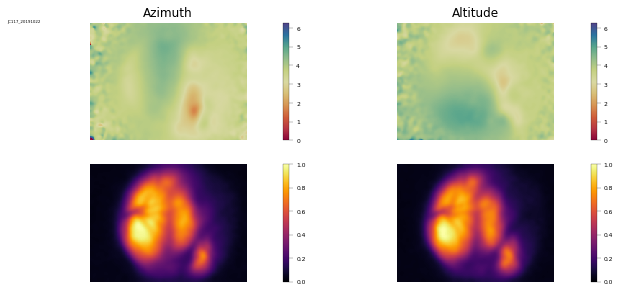

In [453]:
plt.rcParams['svg.fonttype'] = 'none'

pwr_cmap='inferno'
cmap='dark_%s' % colormap
fig = plt.figure(figsize=(9,4))
fig.patch.set(alpha=0)
azi_map = mapdata['azimuth']['phase'].copy() #mapdata['azimuth'].copy()
alt_map = mapdata['altitude']['phase'].copy()
azi_pwr = mapdata['azimuth']['%s' % power_metric]/mapdata['azimuth']['%s' % power_metric].max()
alt_pwr = mapdata['altitude']['%s' % power_metric]/mapdata['altitude']['%s' % power_metric].max()

fig.add_subplot(221)
plt.imshow(azi_map, cmap=cmap, vmin=vmin, vmax=vmax, alpha=1)
plt.colorbar()
plt.title('Azimuth')
plt.axis('equal')
plt.axis('off')

fig.add_subplot(222)
plt.imshow(alt_map, cmap=cmap,  vmin=vmin, vmax=vmax, alpha=1)
plt.colorbar()
plt.title('Altitude')
plt.axis('equal')
plt.axis('off')

fig.add_subplot(223)
plt.imshow(azi_pwr, cmap=pwr_cmap, vmin=0, vmax=1)
plt.colorbar()
plt.axis('equal')
plt.axis('off')

fig.add_subplot(224)
plt.imshow(alt_pwr, cmap=pwr_cmap,  vmin=0, vmax=1)
plt.colorbar()
plt.axis('equal')
plt.axis('off')

fig.text(0.01,0.95, data_id, fontsize=4)
plt.subplots_adjust(left=0.1, right=0.97, bottom=0.05, top=0.95)

pl.savefig(os.path.join(signmapdir, 'inputmaps__%s_%s.svg' % (animalid, sesh)))
pl.savefig(os.path.join(dst_dir, 'inputmaps__%s_%s.svg' % (animalid, sesh)))

In [397]:
mapdata['azimuth'].keys()

['phase', 'magRatio']

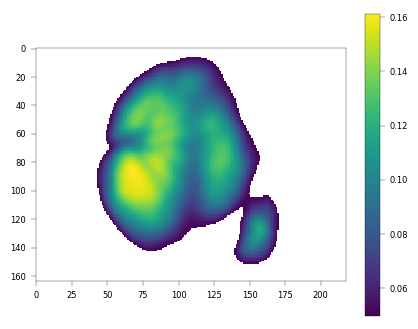

In [405]:
#mean_pwr = (alt_pwr+azi_pwr)/2.
mean_pwr = mapdata['azimuth']['magRatio']
plt.figure()

pwr_msk = mean_pwr.copy()
pwr_msk[pwr_msk<0.05] = np.nan
plt.imshow(pwr_msk)
plt.colorbar()

#### Convert to linear (screen) range

In [221]:
screen_w, screen_h = (117, 67)
screen_w_deg = screen_w/2.
screen_h_deg = screen_h/2.

print(screen_w_deg, screen_h_deg)


(58.5, 33.5)


Old min/max: 0.00, 6.28
[AZI] New min/max: -58.50, 58.50
[ALT] New min/max: -58.50, 58.50
(-57.9772367190665, 58.063428133600354)


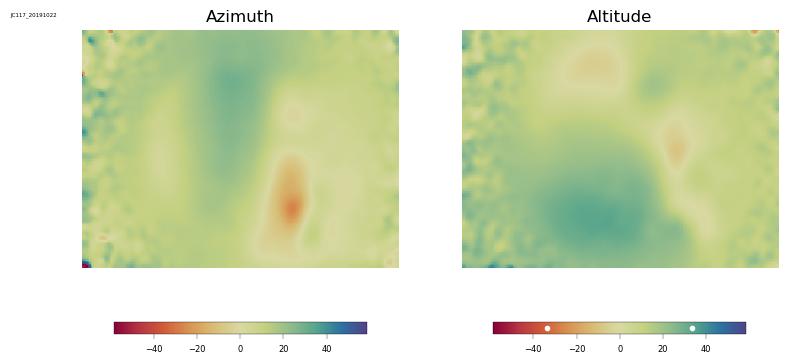

In [463]:
lmin_azi, lmax_azi = (-screen_w_deg, screen_w_deg)
lmin_alt, lmax_alt = (-screen_w_deg, screen_w_deg) #(-33.66, 33.66)
screen_h_min, screen_h_max = (-screen_h_deg, screen_h_deg)

print("Old min/max: %.2f, %.2f" % (vmin, vmax))
print("[AZI] New min/max: %.2f, %.2f" % (lmin_azi, lmax_azi))
print("[ALT] New min/max: %.2f, %.2f" % (lmin_alt, lmax_alt))


azi_lin = convert_range(azi_map, newmin=lmin_azi, newmax=lmax_azi, oldmin=vmin, oldmax=vmax)
alt_lin = convert_range(alt_map, newmin=lmin_alt, newmax=lmax_alt, oldmin=vmin, oldmax=vmax)

#azi_lin[mean_pwr<=0.02]=np.nan
#alt_lin[mean_pwr<=0.02]=np.nan

#phase_el_smooth = convert_range(phase_el_smooth, newmin=lmin_alt, newmax=lmax_alt, oldmin=vmin_el, oldmax=vmax_el)
#print("phase min/max: %.2f / %.2f" % (phase_az_smooth.min(), phase_az_smooth.max()))

print(azi_lin.min(), azi_lin.max())
fig = plt.figure(figsize=(8,4), dpi=100)

ax = fig.add_subplot(121)
ax.set_title('Azimuth')
im = ax.imshow(azi_lin, cmap=cmap, vmin=lmin_azi, vmax=lmax_azi)
pl.colorbar(im, orientation='horizontal', shrink=0.8)
ax.axis('off')

ax = fig.add_subplot(122)
ax.set_title('Altitude')
im1 = ax.imshow(alt_lin, cmap=cmap, vmin=lmin_alt, vmax=lmax_alt)
cb = pl.colorbar(im1, orientation='horizontal', shrink=0.8)
ax.axis('off')


screen_lim_pos = (lmax_alt-screen_h_max)/(lmax_alt*2.)
cb.ax.plot(screen_lim_pos, 0.5, 'w.') # my data is between 0 and 1
cb.ax.plot(1-screen_lim_pos, 0.5, 'w.') # my data is between 0 and 1

# cb.ax.axvline(x=screen_h_min, c='w')          # line at 3

fig.text(0.01,0.95, data_id, fontsize=4)
plt.subplots_adjust(left=0.1, right=0.97, bottom=0.05, top=0.95)

pl.savefig(os.path.join(signmapdir, 'linphase__%s_%s.svg' % (animalid, sesh)))
pl.savefig(os.path.join(dst_dir, 'linphase__%s_%s.svg' % (animalid, sesh)))

## filter + smooth

In [464]:
mapdata['azimuth'].keys()

['phase', 'magRatio']

In [465]:
power_metric

'magRatio'

In [466]:
smooth_fwhm = 7
mag_thr=0.025

phase_az_raw = mapdata['azimuth']['phase'].copy()
phase_el_raw = mapdata['altitude']['phase'].copy()
print(phase_el_raw.min(), phase_el_raw.max())

mag_az_raw = mapdata['azimuth'][power_metric].copy()
mag_el_raw = mapdata['altitude'][power_metric].copy()

phase_az_smooth = shift_map(smooth_array(phase_az_raw, smooth_fwhm, phaseArray=True))
phase_el_smooth = shift_map(smooth_array(phase_el_raw, smooth_fwhm, phaseArray=True))
print(phase_el_smooth.min(), phase_el_smooth.max())

mag_az_smooth = smooth_array(mag_az_raw, smooth_fwhm, phaseArray=False)
mag_el_smooth = smooth_array(mag_el_raw, smooth_fwhm, phaseArray=False)

# THR by mag
# phase_az_smooth[mag_az_smooth<mag_thr] = 0
# phase_el_smooth[mag_az_smooth<mag_thr] = 0 
# phase_el_smooth[mag_el_smooth<mag_thr] = 0 
# phase_az_smooth[mag_el_smooth<mag_thr] = 0

# normalize power
altitude_power_map_normed = mag_el_smooth/mag_el_smooth.max()
azimuth_power_map_normed = mag_az_smooth/mag_az_smooth.max()


(1.8055755745705675, 5.542998724475603)
(1.3020526943161916, 3.5383612394694275)


In [467]:
phase_az_smooth.min(), phase_az_smooth.max()

(0.04120146521899798, 4.450056015050615)

In [468]:
print("max pwr: %.4f" % mag_az_smooth.max())
print("phase min/max: %.2f / %.2f" % (phase_az_smooth.min(), phase_az_smooth.max()))
print("phase min/max: %.2f / %.2f" % (phase_el_smooth.min(), phase_el_smooth.max()))

max pwr: 0.1597
phase min/max: 0.04 / 4.45
phase min/max: 1.30 / 3.54


In [469]:
## Convert to degrees
in_degrees = True

if shift:
    vmin_az, vmax_az = 0, 2*np.pi
    vmin_el, vmax_el = 0, 2*np.pi
else:
    vmin_az, vmax_az = -np.pi, np.pi # (0, 120)
    vmin_el, vmax_el = -np.pi, np.pi # (-40, 60)

#vmin_az, vmax_az = (phase_az_smooth[~np.isnan(phase_az_smooth)].min(), phase_az_smooth[~np.isnan(phase_az_smooth)].max())
#vmin_el, vmax_el = (phase_el_smooth[~np.isnan(phase_el_smooth)].min(), phase_el_smooth[~np.isnan(phase_el_smooth)].max())

lmin_azi, lmax_azi = (-59.78, 59.78)
lmin_alt, lmax_alt = (-33.66, 33.66)

phase_az_smooth = convert_range(phase_az_smooth, newmin=lmin_azi, newmax=lmax_azi, oldmin=vmin_az, oldmax=vmax_az)
phase_el_smooth = convert_range(phase_el_smooth, newmin=lmin_azi, newmax=lmax_azi, oldmin=vmin_el, oldmax=vmax_el)

print("phase min/max: %.2f / %.2f" % (phase_az_smooth.min(), phase_az_smooth.max()))

# # THR by mag
phase_az_smooth[mag_az_smooth<mag_thr] = 0
phase_el_smooth[mag_az_smooth<mag_thr] = 0 
phase_el_smooth[mag_el_smooth<mag_thr] = 0 
phase_az_smooth[mag_el_smooth<mag_thr] = 0


phase min/max: -59.00 / 24.90


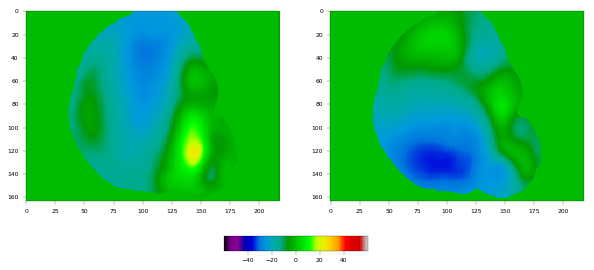

In [470]:
fig, axn = plt.subplots(1,2, figsize=(10,4))
ax=axn[0]
im = ax.imshow(phase_az_smooth, cmap='nipy_spectral', vmin=lmin_azi, vmax=lmax_azi)
ax=axn[1]
ax.imshow(phase_el_smooth, cmap='nipy_spectral', vmin=lmin_azi, vmax=lmax_azi)

cbar_ax = fig.add_axes([0.4, 0, 0.2, 0.05])
plt.colorbar(im, cax=cbar_ax, orientation='horizontal')



In [471]:
lmin_azi, lmax_azi

(-59.78, 59.78)

# Defining image analysis parameters  

#### This is probably the most important part of the whole analysis! The 14 parameters below define the final segmentation results.  
<br>
* phaseMapFilterSigma: The sigma value (in pixels) of Gaussian filter for altitude and azimuth maps. FLOAT, default = 1.0, recommended range: [0.0, 2.0]. Large "phaseMapFilterSigma" gives you more patches. Small "phaseMapFilterSigma" gives you less patches.
<br><br>
* signMapFilterSigma: The sigma value (in pixels) of Gaussian filter for visual sign maps. FLOAT, default = 9.0, recommended range: [0.6, 10.0]. Large "signMapFilterSigma" gives you less patches. Small "signMapFilterSigma" gives you more patches.
<br><br>
* signMapThr: Threshold to binarize visual signmap. FLOAT, default = 0.35, recommended range: [0.2, 0.5], allowed range: [0, 1). Large signMapThr gives you fewer patches. Smaller signMapThr gives you more patches.
<br><br>
* closeIter: Binary close iteration for each raw patches. INT, default = 3. You do not want to change this parameter very often.
<br><br>
* openIter: Binary open iteration for each raw patches. INT, default = 3. You do not want to change this parameter very often
<br><br>
* dilationIter: Binary dilation iteration for each raw patches. INT, default = 15. You do not want to change this parameter very often. 
<br><br>
* borderWidth: Pixel number between adjcent patches. INT, default = 1. You do not want to change this parameter very often.
<br><br>
* smallPatchThr: The patches with pixel number below smallPatchThr will be discarded. INT, default = 100. You do not want to change this parameter very often.
<br><br>
* eccMapFilterSigma: The sigma value of Gaussian filter for eccentricity maps. FLOAT, default = 10.0. You do not want to change this parameter very often.
<br><br>
* visualSpacePixelSize: The pixel size for patch to visual space mapping. FLOAT, default = 0.5. You do not want to change this parameter very often. 
<br><br>
* visualSpaceCloseIter: The binary iteration for visual space coverage for each patch. INT, default = 15. You do not want to change this parameter very often.
<br><br>
* splitLocalMinCutStep: The step width for detecting number of local minimums during spliting. The local minimums detected will be used as marker in the following open cv watershed segmentation. FLOAT, default = 5.0, recommend range: [0.5, 15.0]. Small "splitLocalMinCutStep" will make it more likely to split but into less sub patches. Large "splitLocalMinCutStep" will make it less likely to split but into more sub patches. 
<br><br>
* splitOverlapThr: Patches with overlap ration larger than this value will go through the split procedure. FLOAT, default = 1.1, recommend range: [1.0, 1.2], should be larger than 1.0. Small "splitOverlapThr" will split more patches. Large "splitOverlapThr" will split less patches. 
<br><br>
* mergeOverlapThr: Considering a patch pair (A and B) with same sign, A has visual coverage a deg<sup>2</sup> and B has visual coverage b deg<sup>2</sup> and the overlaping visual coverage between this pair is c deg<sup>2</sup>. Then if (c/a < "mergeOverlapThr") and (c/b < "mergeOverlapThr"), these two patches will be merged. FLOAT, default = 0.1, recommend range: [0.0, 0.2], should be smaller than 1.0. Small "mergeOverlapThr" will merge less patches. Large "mergeOverlapThr" will merge more patches.

In [472]:
reload(rm)
import json

In [473]:
lmin_alt, lmin_azi

(-33.66, -59.78)

# Set output dir

In [474]:
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
base_dir = os.path.join(aggregate_dir, 'widefield-maps', 'signmaps')
dst_dir = os.path.join(base_dir, 'retinotopic-mapper', data_id)

print(dst_dir)
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)


/n/coxfs01/julianarhee/aggregate-visual-areas/widefield-maps/signmaps/retinotopic-mapper/JC117_20191022


In [475]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/widefield-maps/signmaps/retinotopic-mapper/JC117_20191022'

# Creating the RetinotopicMappingTrail object

In [476]:
import json

In [477]:
params_fpath = os.path.join(dst_dir, '%s_params.json' % data_id)

if os.path.exists(params_fpath):
    print("... loading %s" % params_fpath)
    with open(params_fpath, 'r') as f:
        params = json.load(f)
else:   
    params = {
              'phaseMapFilterSigma': 5, # 0,
              'signMapFilterSigma': 5.,
              'signMapThr': 0.35, #0.35, #0.5,
              'eccMapFilterSigma': 9.0, #5., #10.0,
              'splitLocalMinCutStep': 20., #10., #5.,
              'closeIter': 3,
              'openIter': 3,
              'dilationIter': 15,
              'borderWidth': 1,
              'smallPatchThr': 1000, #100,
              'visualSpacePixelSize': 0.5, #0.5, #5,
              'visualSpaceCloseIter': 15,
              'splitOverlapThr': 1.01,
              'mergeOverlapThr': 0.01, #0.01,
              'lmin_alt': lmin_alt,
              'lmax_alt': lmax_alt, 
              'lmin_azi': lmin_azi,
              'lmax_azi': lmax_azi, 

              # preprocessing 
              'mag_thr': mag_thr,
              'smooth_fwhm': smooth_fwhm
              }
    with open(params_fpath, 'w') as f:
        json.dump(params, f, indent=4, sort_keys=True)

... loading /n/coxfs01/julianarhee/aggregate-visual-areas/widefield-maps/signmaps/retinotopic-mapper/JC117_20191022/JC117_20191022_params.json


In [478]:
# altitude_phase_map = shift_map(phase_el_raw.copy()) #phase_el_smooth.copy()
# azimuth_phase_map = shift_map(phase_az_raw.copy()) #phase_az_smooth.copy()
# azimuth_phase_map = convert_range(azimuth_phase_map, newmin=lmin_azi, newmax=lmax_azi, oldmin=vmin_az, oldmax=vmax_az)
# altitude_phase_map = convert_range(altitude_phase_map, newmin=lmin_alt, newmax=lmax_alt, oldmin=vmin_el, oldmax=vmax_el)

vmin_az = 0
vmax_az= 2*np.pi

#phase_az_smooth = convert_range(azi_map, newmin=lmin_azi, newmax=lmax_azi, oldmin=vmin_az, oldmax=vmax_az)
#phase_el_smooth = convert_range(alt_map, newmin=lmin_alt, newmax=lmax_alt, oldmin=vmin_az, oldmax=vmax_az)

altitude_phase_map = alt_lin.copy()
azimuth_phase_map = azi_lin.copy()
altitude_power_map = alt_pwr.copy()
azimuth_power_map = azi_pwr.copy()
# altitude_phase_map = phase_el_smooth.copy()
# azimuth_phase_map = phase_az_smooth.copy()

# altitude_power_map = mag_el_smooth.copy()
# azimuth_power_map = mag_az_smooth.copy()

In [479]:
print(azimuth_phase_map.min(), azimuth_phase_map.max())

(-57.9772367190665, 58.063428133600354)


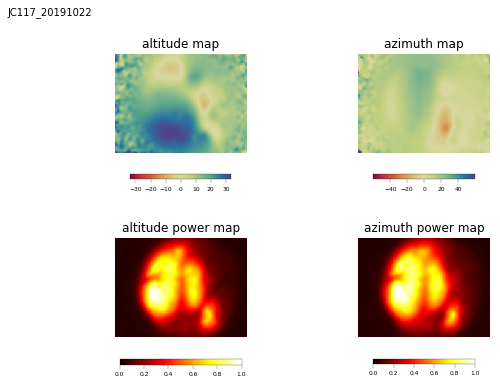

In [509]:
in_degrees = True

f = plt.figure(figsize=(8, 6))
ax1 = f.add_subplot(221)
if in_degrees:
    vmin_az, vmax_az = (lmin_azi, lmax_azi)
    vmin_el, vmax_el = (lmin_alt, lmax_alt)
else:
    if shift:
        vmin_az, vmax_az = 0, 2*np.pi
        vmin_el, vmax_el = 0, 2*np.pi
    else:
        vmin_az, vmax_az = -np.pi, np.pi # (0, 120)
        vmin_el, vmax_el = -np.pi, np.pi # (-40, 60)

fig1 = ax1.imshow(altitude_phase_map, vmin=vmin_el, vmax=vmax_el, cmap=cmap, interpolation='nearest')
ax1.set_axis_off()
ax1.set_title('altitude map')
_ = f.colorbar(fig1, orientation='horizontal', shrink=0.5)

ax2 = f.add_subplot(222)
fig2 = ax2.imshow(azimuth_phase_map, vmin=vmin_az, vmax=vmax_az, cmap=cmap, interpolation='nearest')
ax2.set_axis_off()
ax2.set_title('azimuth map')
_ = f.colorbar(fig2, orientation='horizontal', shrink=0.5)

ax3 = f.add_subplot(223)
fig3 = ax3.imshow(altitude_power_map, vmin=0, vmax=1, cmap='hot', interpolation='nearest')
ax3.set_axis_off()
ax3.set_title('altitude power map')
_ = f.colorbar(fig3, orientation='horizontal', shrink=0.6)

ax4 = f.add_subplot(224)
fig4 = ax4.imshow(azimuth_power_map, vmin=0, vmax=1, cmap='hot', interpolation='nearest')
ax4.set_axis_off()
ax4.set_title('azimuth power map')
_ = f.colorbar(fig4, orientation='horizontal', shrink=0.5)

plt.subplots_adjust(hspace=0.3, wspace=0.2)

label_figure(f, data_id)
plt.savefig(os.path.join(dst_dir, '_%s_input_maps.pdf' % data_id))

# Create trial object

In [77]:
reload(ft)

<module 'retinotopic_mapping.tools.FileTools' from '/home/julianarhee/anaconda2/envs/retinotopic_mapping/lib/python2.7/site-packages/retinotopic_mapping-2.9.4-py2.7.egg/retinotopic_mapping/tools/FileTools.pyc'>

In [481]:

# Create trial object
trial = rm.RetinotopicMappingTrial(altPosMap=alt_lin, #altitude_phase_map,
                                   aziPosMap=azi_lin, #azimuth_phase_map,
                                   altPowerMap=alt_pwr, #altitude_power_map,
                                   aziPowerMap=azi_pwr, #azimuth_power_map,
                                   vasculatureMap=vasculature_map,
                                   mouseID=animalid,
                                   dateRecorded=session,
                                   comments='This is an example.',
                                   params=params)

In [482]:
print trial
print(alt_lin.shape)

A retinotopic mapping trial: 20191022_MJC117
(164, 218)


# Generating visual sign map

In [483]:
trial.getName()

'20191022_MJC117'

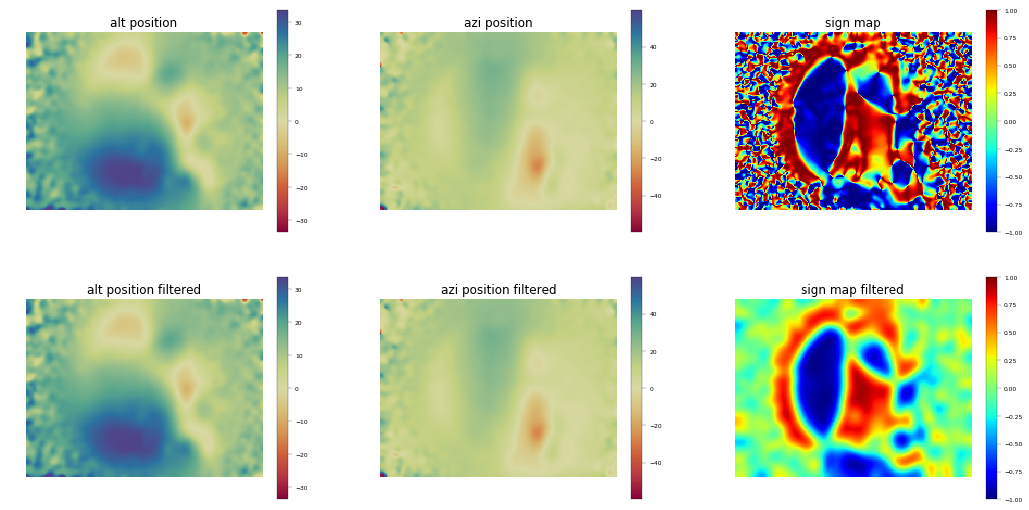

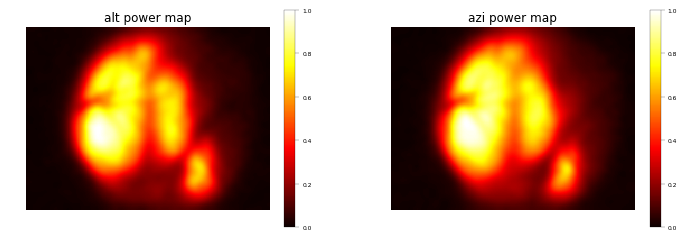

In [513]:
_ = trial._getSignMap(isPlot=True, isFixedRange=True, cmap=cmap)


In [ ]:
# f1 = plot_getSignMap(trial, isFixedRange=True)

# label_figure(f1, data_id)
#plt.savefig(os.path.join(dst_dir, '%s_get_sign_map.png' % data_id))

In [504]:
sfilt = trial.signMapf.copy()
lo=-0.3
hi=0.3
msk = sfilt.copy()
msk = np.ma.masked_where((lo < sfilt) & 
                             (sfilt < hi), sfilt)


#msk = np.ma.array( trial.signMapf.copy(), mask=mask)

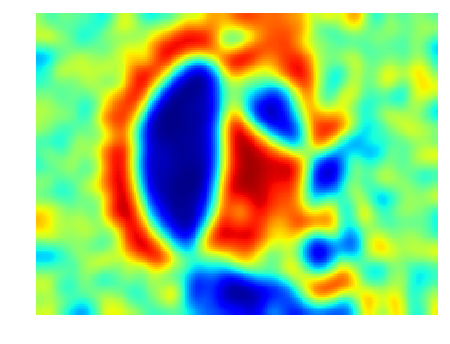

In [512]:
fig, ax = pl.subplots(dpi=100)
im = ax.imshow(sfilt, cmap='jet', vmin=-1, vmax=1)
ax.axis('off')

label_figure(f, data_id)
plt.savefig(os.path.join(dst_dir, '_%s_signmap.pdf' % data_id))
plt.savefig(os.path.join(signmapdir, 'signmap__%s_%s.pdf' % (animalid, sesh)))# data_id))

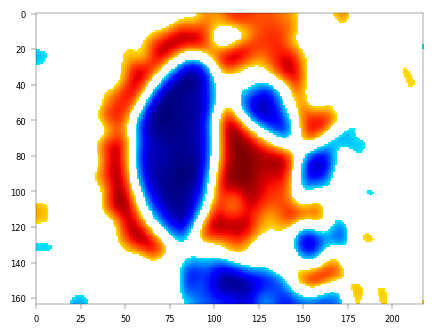

In [508]:
fig, ax = pl.subplots(figsize=(5,4), dpi=100)
im = ax.imshow(msk, cmap='jet')

label_figure(f, data_id)
plt.savefig(os.path.join(dst_dir, '_%s_input_maps.pdf' % data_id))

In [495]:
msk

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20,
  dtype=float64)

In [271]:
trial.signMap

array([[ 0.90769464,  0.99912778,  0.79534974, ...,  0.13185944,
         0.06853232,  0.04804564],
       [ 0.78451569,  0.98291858,  0.86158987, ...,  0.03777513,
        -0.03089904, -0.07993872],
       [ 0.61275758,  0.86149575,  0.97432306, ..., -0.17012444,
        -0.19997679, -0.24748331],
       ...,
       [ 0.29352474,  0.40245722, -0.2465985 , ...,  0.97706452,
         0.89453807,  0.62413958],
       [ 0.11922861,  0.07987681,  0.01194841, ...,  0.88403028,
         0.95601104,  0.6781382 ],
       [ 0.14083681,  0.09487297,  0.03103008, ...,  0.75340723,
         0.98547474,  0.69892525]])

In [245]:
reload(rm)

<module 'retinotopic_mapping.RetinotopicMapping' from '/home/julianarhee/anaconda2/envs/retinotopic_mapping/lib/python2.7/site-packages/retinotopic_mapping-2.9.4-py2.7.egg/retinotopic_mapping/RetinotopicMapping.pyc'>

patch006AU=356.9600000000001 AS=855.5507554181338 ratio=2.3967692610324227
2 local minuma were found!!!
patch007AU=188.68000000000004 AS=215.18567256712748 ratio=1.1404795026877648
Only one local minumum was found!!!
patch004AU=176.28000000000003 AS=182.4461270290306 ratio=1.0349791639949544
Only one local minumum was found!!!
patch005AU=342.7200000000001 AS=343.6458566286192 ratio=1.0027014957651117
patch002AU=589.7600000000001 AS=585.682680347224 ratio=0.9930864764433396
patch003AU=952.6800000000002 AS=1491.1841739253236 ratio=1.565251893527022
2 local minuma were found!!!
patch001AU=493.5600000000001 AS=579.1630903992605 ratio=1.1734400891467305
2 local minuma were found!!!
patch008AU=78.36000000000001 AS=83.89588663073854 ratio=1.0706468431692002
Only one local minumum was found!!!
patch009AU=189.32000000000005 AS=204.09801785481204 ratio=1.0780584082759983
Only one local minumum was found!!!
merge iteration: 1
merging: patch001.3 & patch001.2, overlap ratio: 0.0
merge iteration: 2

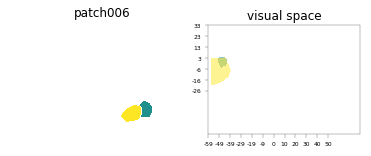

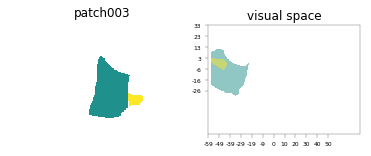

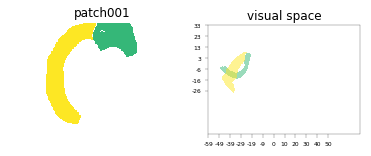

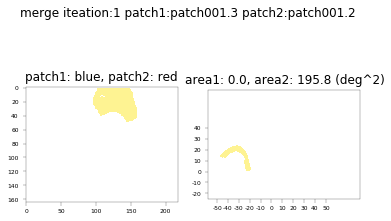

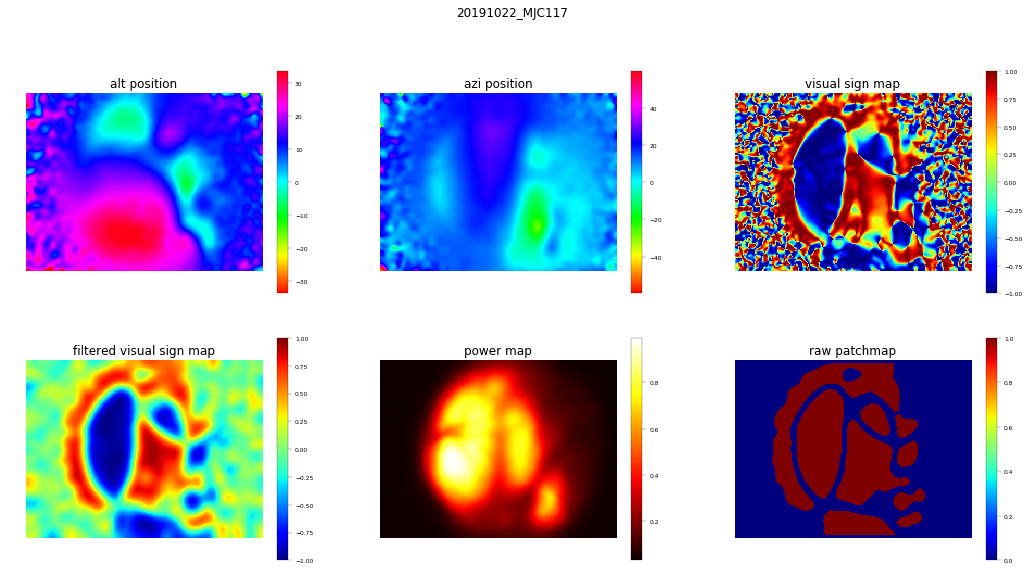

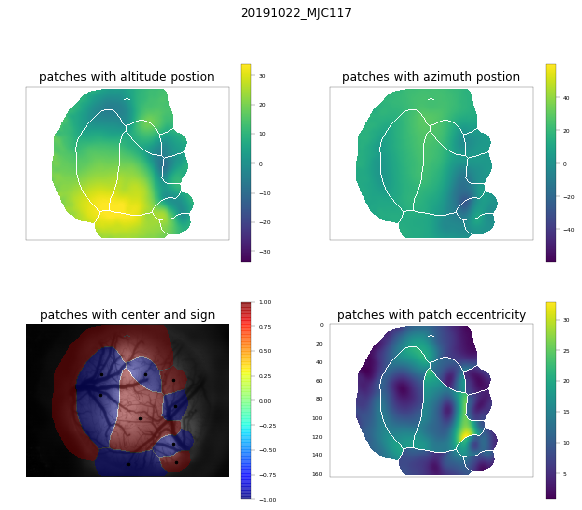

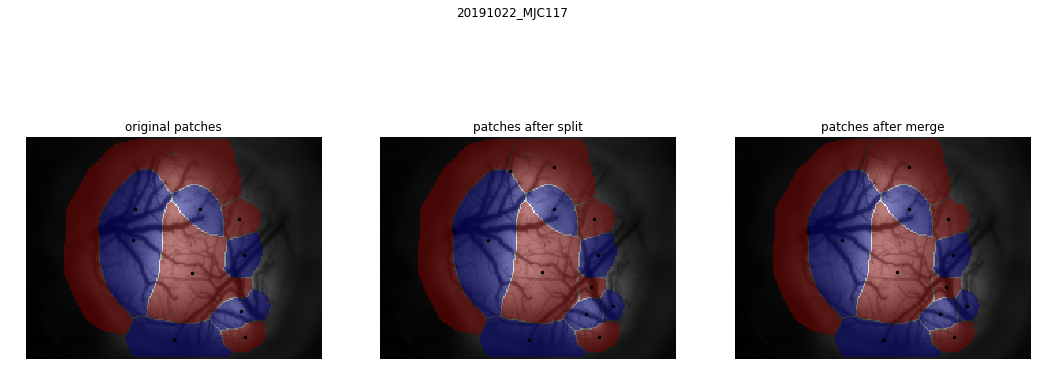

In [514]:
trial.plotTrial(isSave=True, saveFolder=dst_dir)

# Binarizing filtered visual signmap

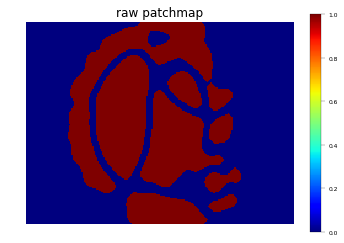

In [515]:
_ = trial._getRawPatchMap(isPlot=True)
plt.show()

# Generating raw patches

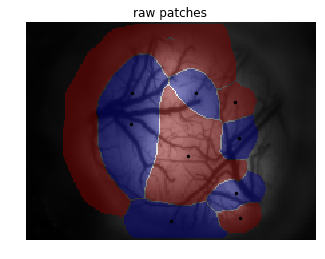

In [516]:
_ = trial._getRawPatches(isPlot=True)
plt.show()

# Generating determinant map

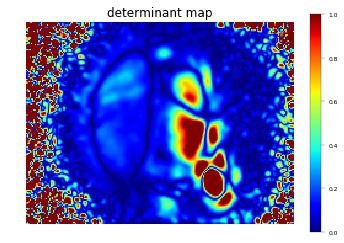

In [517]:
_ = trial._getDeterminantMap(isPlot=True, cmap='jet')
plt.show()

# Generating eccentricity map for each patch

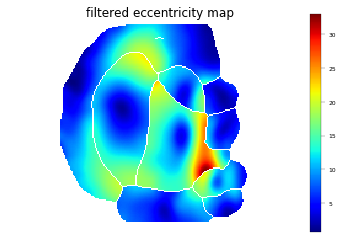

In [518]:
_ = trial._getEccentricityMap(isPlot=True)
plt.show()

# Splitting overlapping patches

patch006AU=356.9600000000001 AS=855.5507554181338 ratio=2.3967692610324227
2 local minuma were found!!!
patch007AU=188.68000000000004 AS=215.18567256712748 ratio=1.1404795026877648
Only one local minumum was found!!!
patch004AU=176.28000000000003 AS=182.4461270290306 ratio=1.0349791639949544
Only one local minumum was found!!!
patch005AU=342.7200000000001 AS=343.6458566286192 ratio=1.0027014957651117
patch002AU=589.7600000000001 AS=585.682680347224 ratio=0.9930864764433396
patch003AU=952.6800000000002 AS=1491.1841739253236 ratio=1.565251893527022
2 local minuma were found!!!
patch001AU=493.5600000000001 AS=579.1630903992605 ratio=1.1734400891467305
2 local minuma were found!!!
patch008AU=78.36000000000001 AS=83.89588663073854 ratio=1.0706468431692002
Only one local minumum was found!!!
patch009AU=189.32000000000005 AS=204.09801785481204 ratio=1.0780584082759983
Only one local minumum was found!!!


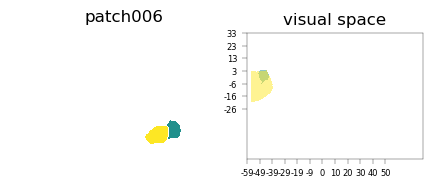

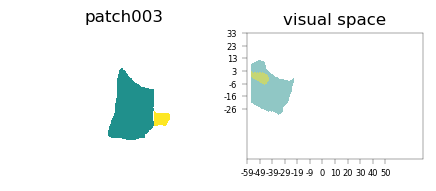

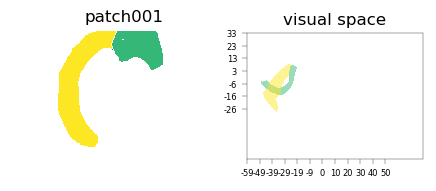

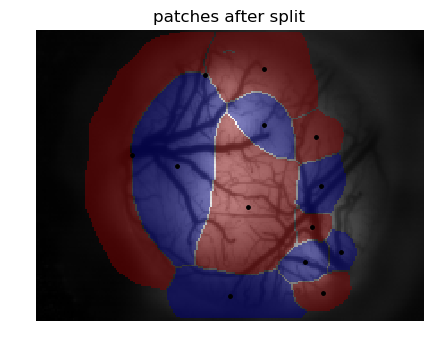

In [248]:
_ = trial._splitPatches(isPlot=True)
plt.show()

# Merging non-overlapping patches

merge iteration: 1


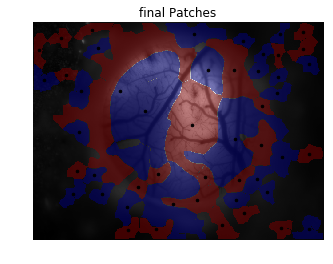

In [264]:
_ = trial._mergePatches(isPlot=True)
plt.show()

## Note:  
### The methods used from cell 8 to cell 14 are protected by leading underscore! Here they were used separately to show every single image analysis step. In real life, the steps from cell 8 to cell 14 can be consolidated into one single method:  

`trial.processTrial(isPlot=True)`

# Plotting results

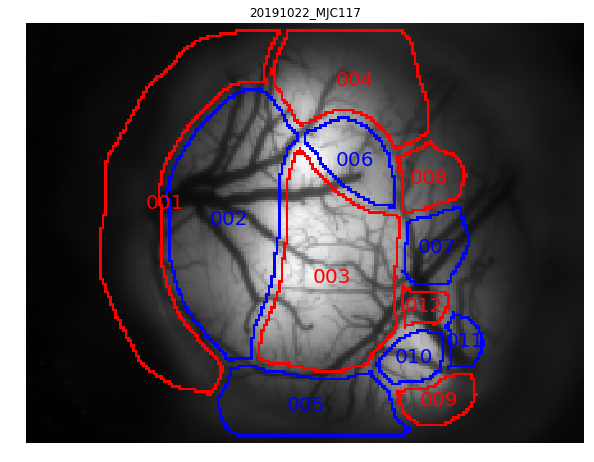

In [520]:
f = trial.plotFinalPatchBorders(borderWidth=2, fontSize=20)

#plt.show()

plt.savefig(os.path.join(dst_dir, '%s_final_patch_borders.png' % trial.getName()))
plt.show()


# Annotating segmented patches

In [521]:
names = [
         ['patch002', 'V1'],
         ['patch003', 'LM'],
         ['patch010', 'LI'],
#          ['patch011', 'LI'],
         ['patch006', 'AL'],
         ['patch009', 'LL'],

    #          ['patch13', 'LL'],
#          ['patch06', 'AM'],
#          ['patch07', 'LI'],
#          ['patch08', 'MMA'],
#          ['patch09', 'AL'],
#          ['patch10', 'RLL'],
#          ['patch11', 'LLA'],
         ]

finalPatchesMarked = dict(trial.finalPatches)

for i, namePair in enumerate(names):
    currPatch = finalPatchesMarked.pop(namePair[0])
    newPatchDict = {namePair[1]:currPatch}
    finalPatchesMarked.update(newPatchDict)
    
trial.finalPatchesMarked = finalPatchesMarked

In [522]:
# import cPickle as pkl
# retmap_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas/widefield-maps/signmaps/retinotopic-mapper'
# fn = os.path.join(retmap_dir, 'JC085_20190620/20200601/20190620_MJC085_results.pkl')
# with open(fn, 'rb') as f:
#     rmap = pkl.load(f)

In [523]:
import dill as pkl

ImportError: No module named dill

In [524]:
rmap_save = dict((k, v) for k, v in rmap.items() if k!='finaPatchesMarked')

In [289]:
fn2 = os.path.join(retmap_dir, 'JC085_20190620/20200601/20190620_MJC085_loadresults.pkl')
with open(fn2, 'wb') as f:
    pkl.dump(rmap_save, f, protocol=2)

PicklingError: Can't pickle <class 'retinotopic_mapping.RetinotopicMapping.Patch'>: it's not the same object as retinotopic_mapping.RetinotopicMapping.Patch

In [ ]:
for k, v in rmap_save.items():
    if isinstance(v, dict):
        for vk, vv in v.items():
            try:
                print(vk, vv.dtype)
            except AttributeError:
                print('Error:', k, vk)
    else:
        if not isinstance(v, str):
            print(k, v.dtype)

In [ ]:
vv

# Ploting final results

In [304]:
plt.rcParams['svg.fonttype'] = 'none'


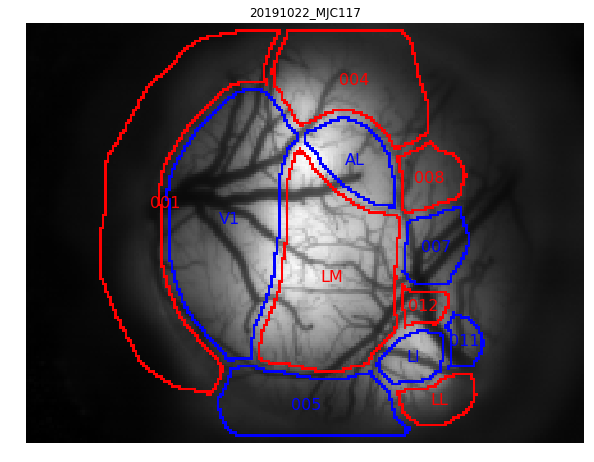

In [525]:
_ = trial.plotFinalPatchBorders()

plt.savefig(os.path.join(dst_dir, '%s_final_patch_borders_labeled.svg' % trial.getName()))

plt.show()

In [526]:

def set_plot_params(lw_axes=0.25, labelsize=6, color='k', dpi=100):
    import pylab as pl
    #### Plot params
    #pl.rcParams['font.size'] = 6
    #pl.rcParams['text.usetex'] = True
    
    pl.rcParams["axes.labelsize"] = labelsize + 2
    pl.rcParams["axes.linewidth"] = lw_axes
    pl.rcParams["xtick.labelsize"] = labelsize
    pl.rcParams["ytick.labelsize"] = labelsize
    pl.rcParams['xtick.major.width'] = lw_axes
    pl.rcParams['xtick.minor.width'] = lw_axes
    pl.rcParams['ytick.major.width'] = lw_axes
    pl.rcParams['ytick.minor.width'] = lw_axes
    pl.rcParams['legend.fontsize'] = labelsize
    
    pl.rcParams['figure.figsize'] = (5, 4)
    pl.rcParams['figure.dpi'] = dpi
    pl.rcParams['savefig.dpi'] = dpi
    pl.rcParams['svg.fonttype'] = 'none' #: path
        
    
    for param in ['xtick.color', 'ytick.color', 'axes.labelcolor', 'axes.edgecolor']:
        pl.rcParams[param] = color

    return 
    
set_plot_params()

Can not find necessary visual areas (V1, LM, RL) for normalization. 
Setting origins to 0 ...


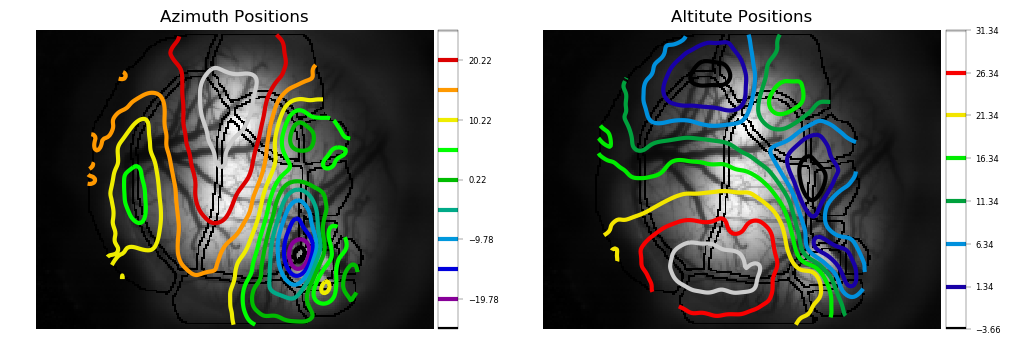

In [527]:
fig, axn = plt.subplots(1,2, figsize=(12,6))

contour_alt, contour_azi = trial.plotContours(cmap='nipy_spectral', inline=False, 
                                              altAxis=axn[1], aziAxis=axn[0], )


plt.savefig(os.path.join(dst_dir, 'contour_plots_fullres_%s.svg' % trial.getName()))


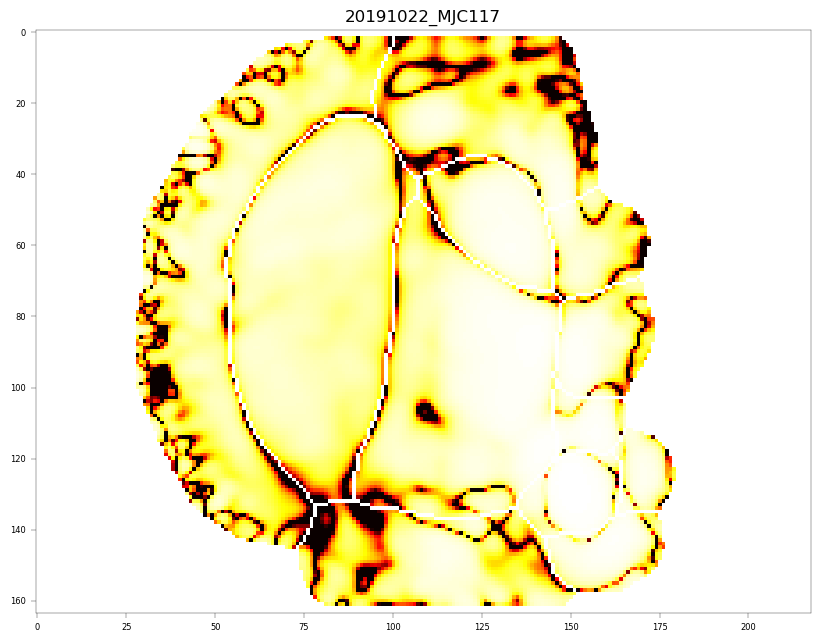

In [530]:
trial.plotMagnificationMap()

In [534]:
def plotContours(trial, isNormalize=True, altLevels=np.arange(-30., 50., 5.), aziLevels=np.arange(0., 120., 5.),
                 isPlottingBorder=True, inline=False, lineWidth=3, figSize=(12, 12), fontSize=15, altAxis=None,
                 aziAxis=None, cmap='hsv', contourInterval=5.0, borderWidth=2):
    """
    plot contours of altitute posititon and azimuth position

    isNormalize: is resetting the origin of visual field
    """
    altLevels = np.arange(trial.params['lmin_alt'], trial.params['lmax_alt'], contourInterval)
    aziLevels = np.arange(trial.params['lmin_azi'], trial.params['lmax_azi'], contourInterval)
    if not hasattr(self, 'altPosMapf'):
        self._getSignMap(cmap=cmap)

    altPosMap = trial.altPosMapf
    aziPosMap = trial.aziPosMapf

    if isNormalize:
        altPosOrigin, aziPosOrigin = trial.getVisualFieldOrigin()
        altPosMap = altPosMap - altPosOrigin
        aziPosMap = aziPosMap - aziPosOrigin

    if hasattr(self, 'vasculatureMap') and type(trial.vasculatureMap) != type(None) and isPlottingBorder:
        zoom = trial.vasculatureMap.shape[0] / altPosMap.shape[0]
        altPosMap = ni.zoom(altPosMap, zoom)
        aziPosMap = ni.zoom(aziPosMap, zoom)
        totalMask = ni.zoom(trial._generateTotalMask().astype(np.float32), zoom)
        altPosMap[totalMask < 0.5] = np.nan
        aziPosMap[totalMask < 0.5] = np.nan
    else:
        totalMask = trial._generateTotalMask()
        altPosMap[totalMask == 0] = np.nan
        aziPosMap[totalMask == 0] = np.nan

    X, Y = np.meshgrid(np.arange(altPosMap.shape[1]),
                       np.arange(altPosMap.shape[0]))

    # plotting altitute contours
    if not altAxis:
        altf = plt.figure(figsize=figSize, facecolor='#ffffff')
        altAxis = altf.add_subplot(111)

    altContour = altAxis.contour(X,
                                 Y,
                                 altPosMap,
                                 inline=inline,
                                 levels=altLevels,
                                 linewidths=lineWidth,
                                 cmap=cmap)

    if inline:
        altContour.clabel(inline=inline, fontsize=fontSize, fmt='%1.1f')
    else:
        #altAxis.get_figure().colorbar(altContour)
        divider = make_axes_locatable(altAxis) #ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        altAxis.get_figure().colorbar(altContour, cax=cax)


    if isPlottingBorder:
        trial.plotFinalPatchBorders(plotAxis=altAxis,
                                   plotName=False,
                                   isTitle=False,
                                   isColor=False,
                                   borderWidth=borderWidth,
                                   interpolation='bilinear')

    altAxis.set_title('Altitute Positions')

    # plotting azimuth contours
    if not aziAxis:
        azif = plt.figure(figsize=figSize, facecolor='#ffffff')
        aziAxis = azif.add_subplot(111)

    aziContour = aziAxis.contour(X,
                                 Y,
                                 aziPosMap,
                                 inline=inline,
                                 levels=aziLevels,
                                 linewidths=lineWidth,
                                 cmap=cmap)
    if inline:
        aziContour.clabel(inline=1, fontsize=fontSize, fmt='%1.1f')
    else:
        #aziAxis.get_figure().colorbar(aziContour)
        divider = make_axes_locatable(aziAxis) #ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        aziAxis.get_figure().colorbar(aziContour, cax=cax)


    if isPlottingBorder:
        trial.plotFinalPatchBorders(plotAxis=aziAxis,
                                   plotName=False,
                                   isTitle=False,
                                   isColor=False,
                                   borderWidth=borderWidth,
                                   interpolation='bilinear')

    aziAxis.set_title('Azimuth Positions')

    return altAxis, aziAxis



# Generating dictionary for saving

In [293]:
trialDict = trial.generateTrialDict()
trialDict.keys()

['eccentricityMapf',
 'mouseID',
 'aziPowerMap',
 'altPosMapf',
 'altPowerMap',
 'aziPowerMapf',
 'comments',
 'aziPosMap',
 'altPosMap',
 'finalPatchesMarked',
 'signMapf',
 'params',
 'finalPatches',
 'vasculatureMap',
 'signMap',
 'dateRecorded',
 'altPowerMapf',
 'rawPatchMap',
 'aziPosMapf']

# Saving results

In [294]:
results_fpath = os.path.join(dst_dir, '%s_results.pkl' % trial.getName())
ft.saveFile(results_fpath, trialDict)
print("saved results: ", results_fpath)

('saved results: ', '/n/coxfs01/julianarhee/aggregate-visual-areas/widefield-maps/signmaps/retinotopic-mapper/JC117_20191022/20191022_MJC117_results.pkl')


In [295]:
results_fpath

'/n/coxfs01/julianarhee/aggregate-visual-areas/widefield-maps/signmaps/retinotopic-mapper/JC117_20191022/20191022_MJC117_results.pkl'

In [296]:
class struct():
    pass

In [297]:
def label_patch(patch, key, plotAxis=None, plotColor='w', fontSize=16, zoom=1):
    #if plotName:
    
    if plotAxis is None:
        fig, plotAxis = pl.subplots()
    center = patch.getCenter()
    abbrev_key = key.split('patch')[-1]
    plotAxis.text(center[1] * zoom, center[0] * zoom, abbrev_key, verticalalignment='center',
                  horizontalalignment='center', color=plotColor, fontsize=fontSize)

    return plotAxis
                

In [298]:
patches = {}
for area_label, area_patch in trial.finalPatchesMarked.items():
    if 'patch' in area_label:
        continue
    patches.update({area_label: area_patch})

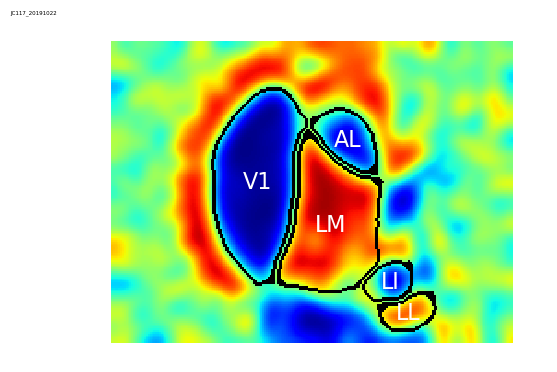

In [368]:
fig, ax = plt.subplots(figsize=(6,4))
fig.patch.set(alpha=0)

ax.imshow(trial.signMapf, cmap='jet', vmin=-1, vmax=1)


for vlabel, vpatch in patches.items():
    curr_patch_border = vpatch.getBorder()
    # plt.imshow(vpatch.getMask())
    pt.plot_mask(curr_patch_border, plotAxis=ax, color='k', borderWidth=1, closingIteration=3)
    label_patch(vpatch, vlabel, plotAxis=ax, plotColor='w')
    
plt.axis('equal')
plt.axis('off')
fig.text(0.01, 0.95, data_id, fontsize=4)
plt.savefig(os.path.join(dst_dir, 'labeled_patches_clean_%s_SIGN.svg' % trial.getName()))


In [ ]:
trial.altPowerMapf

In [324]:
import sys
!conda install --yes --prefix {sys.prefix} seaborn

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.5
  latest version: 4.10.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/julianarhee/anaconda2/envs/retinotopic_mapping

  added / updated specs:
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2021.4.13  |       h06a4308_1         114 KB
    openssl-1.1.1k             |       h27cfd23_0         2.5 MB
    pandas-0.24.2              |   py27hb3f55d8_0        10.9 MB  conda-forge
    patsy-0.5.1                |           py27_0         274 KB
    seaborn-0.9.0              |           py27_0         360 KB
    statsmodels-0.9.0          |py27h3010b51_1000         8.7 MB  conda-forge
    ------------------------------------------------------------
                           

In [325]:
import seaborn as sns

In [369]:
# Load colormap
colormap ='batlow'#  'nic_Edge'
cmapdir = '/n/coxfs01/julianarhee/colormaps' #os.path.join(aggr_dir, 'colormaps')
cdata = np.loadtxt(os.path.join(cmapdir, colormap) + ".txt")
cmap_phase = LinearSegmentedColormap.from_list('my_colormap', cdata[::-1])

    

In [371]:
lmin_azi, lmax_azi

(-59.78, 59.78)

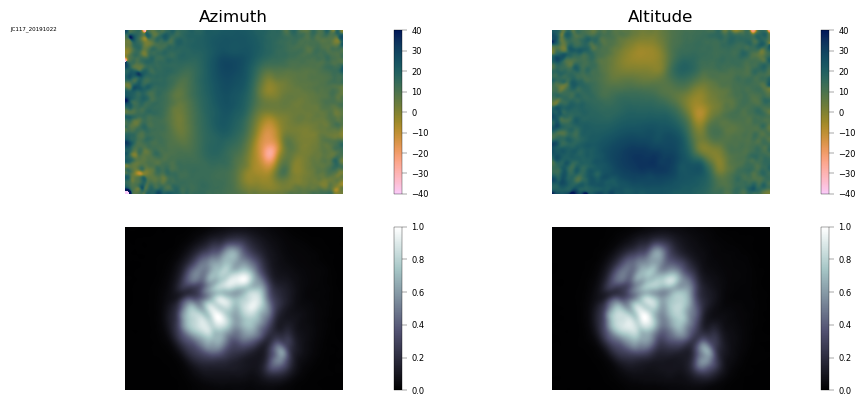

In [411]:
vmin=-40
vmax=40

cmap = cmap_phase
fig = plt.figure(figsize=(9,4))
fig.patch.set(alpha=0)
azi_map = trial.aziPosMap.copy() #mapdata['azimuth'].copy()
alt_map = trial.altPosMap.copy()
azi_pwr = trial.aziPowerMap.copy()
alt_pwr = trial.altPowerMap.copy()

fig.add_subplot(221)
plt.imshow(azi_map, cmap=cmap, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Azimuth')
plt.axis('equal')
plt.axis('off')

fig.add_subplot(222)
plt.imshow(alt_map, cmap=cmap,  vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Altitude')
plt.axis('equal')
plt.axis('off')

fig.add_subplot(223)
plt.imshow(azi_pwr, cmap='bone', vmin=0, vmax=1)
plt.colorbar()
plt.axis('equal')
plt.axis('off')

fig.add_subplot(224)
plt.imshow(alt_pwr, cmap='bone',  vmin=0, vmax=1)
plt.colorbar()
plt.axis('equal')
plt.axis('off')

fig.text(0.01,0.95, data_id, fontsize=4)
plt.subplots_adjust(left=0.1, right=0.97, bottom=0.05, top=0.95)
plt.savefig(os.path.join(dst_dir, 'input_maps.svg'))

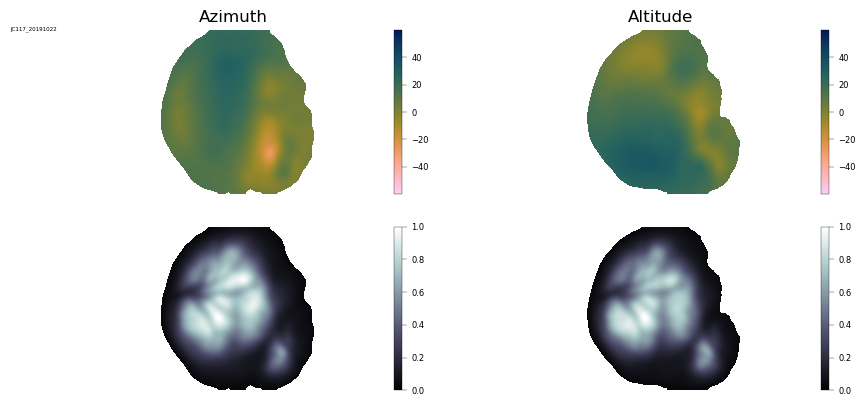

In [412]:
mag_thr=0.02

#mean_pwr = (alt_pwr+azi_pwr)/2.
magthr_azi = mapdata['azimuth']['magRatio'].copy()
magthr_alt = mapdata['altitude']['magRatio'].copy()

azi_map[magthr_azi<=mag_thr] = np.nan #mean_pwr.copy() #mapdata['azimuth'].copy()
alt_map[magthr_alt<=mag_thr] = np.nan 
azi_pwr[magthr_azi<=mag_thr] = np.nan 
alt_pwr[magthr_alt<=mag_thr] = np.nan 


vmin=lmin_azi
vmax=lmax_azi

cmap = cmap_phase
fig = plt.figure(figsize=(9,4))
fig.patch.set(alpha=0)

fig.add_subplot(221)
plt.imshow(azi_map, cmap=cmap, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Azimuth')
plt.axis('equal')
plt.axis('off')

fig.add_subplot(222)
plt.imshow(alt_map, cmap=cmap,  vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Altitude')
plt.axis('equal')
plt.axis('off')

fig.add_subplot(223)
plt.imshow(azi_pwr, cmap='bone', vmin=0, vmax=1)
plt.colorbar()
plt.axis('equal')
plt.axis('off')

fig.add_subplot(224)
plt.imshow(alt_pwr, cmap='bone',  vmin=0, vmax=1)
plt.colorbar()
plt.axis('equal')
plt.axis('off')

fig.text(0.01,0.95, data_id, fontsize=4)
plt.subplots_adjust(left=0.1, right=0.97, bottom=0.05, top=0.95)
plt.savefig(os.path.join(dst_dir, 'input_maps_thr%.2f.svg' % mag_thr))

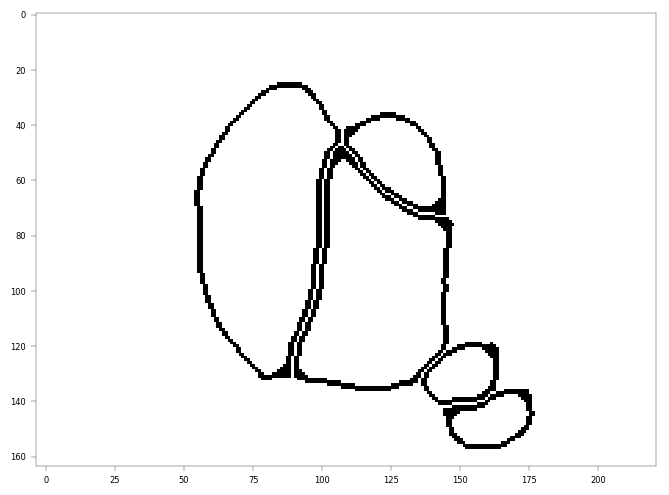

In [300]:
# pmask = currpatch.getMask()
# tmask = testpatch.getMask()


fig, ax = plt.subplots(figsize=(8,6))
#ax.imshow(vasculature_map, cmap='gray')
fig.patch.set(alpha=0)

for vlabel, vpatch in patches.items():
    curr_patch_border = vpatch.getBorder()
    # plt.imshow(vpatch.getMask())
    pt.plot_mask(curr_patch_border, plotAxis=ax, color='k', borderWidth=1, closingIteration=3)
    
    label_patch(vpatch, vlabel, plotAxis=ax, plotColor='w')
    
plt.axis('equal')
plt.savefig(os.path.join(dst_dir, 'labeled_patches_clean_%s_nosurface.svg' % trial.getName()))


## Load 2p fov

In [268]:
import cPickle as pkl

In [164]:
rootdir = '/n/coxfs01/2p-data'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

coreg_dir = os.path.join(rootdir, animalid, 'coreg')
coreg_dfile = os.path.join(coreg_dir, 'alignment_results.pkl')

with open(coreg_dfile, 'rb') as f:
    coreg = pkl.load(f)
    


IOError: [Errno 2] No such file or directory: '/n/coxfs01/2p-data/JC085/coreg/alignment_results.pkl'

In [578]:
trial.aziPosMap.shape

(492, 656)

In [579]:
warped_rois = coreg['rois'].warped.astype(np.uint8)
roi_d1, roi_d2, nrois = warped_rois.shape
roi_img = warped_rois.sum(axis=-1).astype(np.uint8)

warped_fov2p = coreg['zproj'].warped.copy()


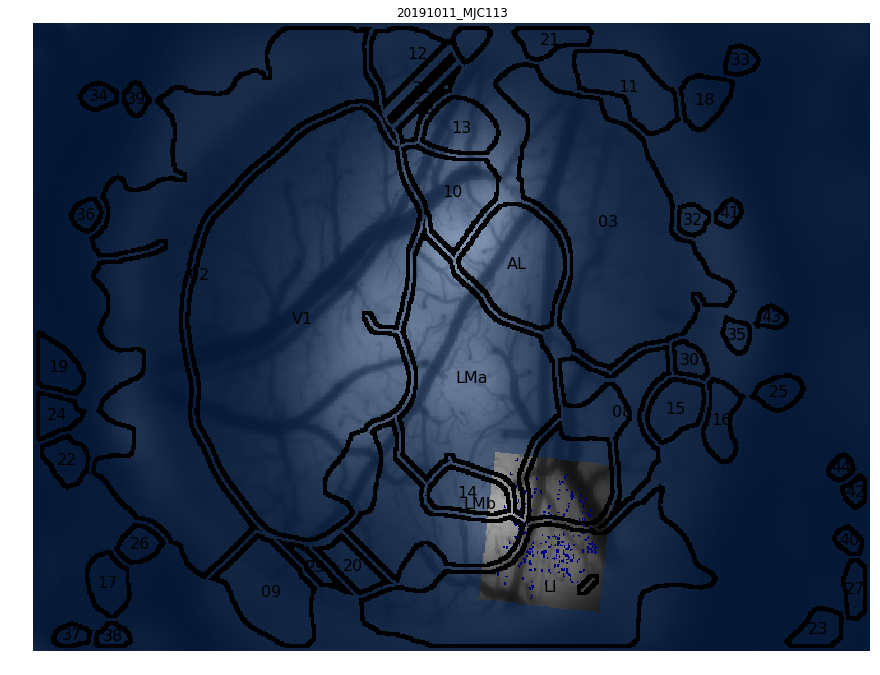

In [771]:

roi_img_overlay = roi_img.astype(bool).copy().astype(float)
roi_img_overlay[roi_img==0] = np.nan
fov2p_overlay = np.ma.masked_array(warped_fov2p==0, warped_fov2p)
# fov2p_overlay = fov2p_r.copy().astype(float)
# fov2p_overlay[fov2p_r==0] = np.nan

fig, ax = plt.subplots(figsize=(8,8))
fig.axes[0].imshow(vasculature_map, cmap='gray')
fig.axes[0].imshow(fov2p_overlay, alpha=.5, cmap='Blues_r')
fig.axes[0].imshow(roi_img_overlay, alpha=1, cmap='jet')


fig = trial.plotFinalPatchBorders(plotAxis=ax, isColor=False, plotVasMap=False, borderWidth=4 )
#fig.axes[0].axis('on')


In [630]:
curr_visual_area = 'LI'
curr_patch = trial.finalPatchesMarked[curr_area]

('patch range:', 0.0, 1.0)


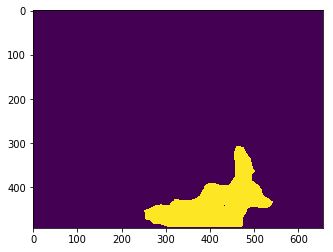

In [634]:
curr_patch_mask = curr_patch.getMask().copy()
curr_patch_mask[np.isnan(curr_patch.getMask())] = 0

plt.figure()
plt.imshow(curr_patch_mask)
print("patch range:", curr_patch_mask.min(), curr_patch_mask.max())

In [769]:
[r for r in np.arange(0, nrois) if not warped_rois[:,:,r].max() > 0]

[]

In [639]:
bool_rois = warped_rois.astype(bool).astype(int)
print(bool_rois.shape)
included_rois = np.array([ri for ri in np.arange(0, nrois) if ((bool_rois[:, :, ri] + curr_patch_mask) > 1).any()])
print("%i of %i ROIs included in area %s" % (len(included_rois), nrois, curr_visual_area))
      

(492, 656, 210)
124 of 210 ROIs included in area LI


In [676]:
included_rois_masks = bool_rois[:, :, included_rois].copy()
included_rois_masks.shape

included_rois_all = included_rois_masks.sum(axis=-1)
included_rois_overlay = included_rois_all.astype(float)
included_rois_overlay[included_rois_all==0] = np.nan

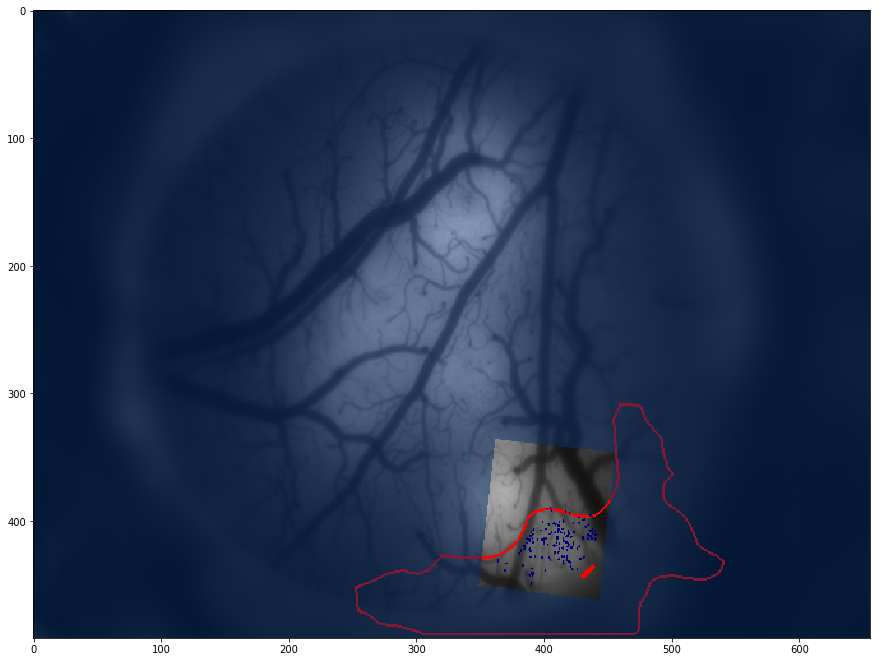

In [679]:
curr_patch_border = curr_patch.getBorder()
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(vasculature_map, cmap='gray')
pt.plot_mask(curr_patch_border, plotAxis=ax, borderWidth=2, closingIteration=2)
ax.imshow(fov2p_overlay, alpha=.5, cmap='Blues_r')
ax.imshow(included_rois_overlay, alpha=1, cmap='jet')


In [680]:
included_rois

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  32,  33,  51,  52,  53,  54,  55,  56,  57,
        58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
       136, 137, 162, 164, 187, 188, 189])

In [681]:
animalid

'JC113'

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [580]:
def get_roi_centroid(roi_mask):

    ret,thresh = cv2.threshold(roi_mask,127,255,0)
    M = cv2.moments(thresh)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    #M.keys()
    
    return (cX, cY)


def remap_scaled_point(orig_point, resize_factor=(0.33, 0.33)):
    orig_point = list(orig_point)
    scaled_point = (round(orig_point[0]*resize_factor[0]), round(orig_point[1]*resize_factor[1]))
                    
    return scaled_point

In [581]:
# target_d1, target_d2 = trial.vasculatureMap.shape
# print(target_d1, target_d2)
# masks_d1, masks_d2 = roi_img.shape

# ds_factor = int(round(float(masks_d1)/target_d1))
# print(ds_factor)

# ctrs = [get_roi_centroid(warped_rois[:, :, ri]) for ri in np.arange(0, nrois)]
# cX = [c[0] for c in ctrs]
# cY = [c[1] for c in ctrs]

(492, 656)
1


In [584]:
# target_d1, target_d2 = trial.vasculatureMap.shape
# print(target_d1, target_d2)
# masks_d1, masks_d2 = roi_img.shape

# ds_factor = int(round(float(masks_d1)/target_d1))
# print(ds_factor)
# resize_d1 = float(target_d1)/masks_d1
# resize_d2 = float(target_d2)/masks_d2


# if masks_d1 != masks_d2:
#     #rois_r = np.dstack([cv2.resize(warped_rois[:,:,ri], (target_d2, target_d1)) for ri in np.arange(0, nrois)])
#     #fov2p_r = cv2.resize(warped_fov2p.astype(np.uint8), (target_d2, target_d1), interpolation=cv2.INTER_NEAREST)
#     fov2p_r = cv2.resize(warped_fov2p.astype(np.uint8), (target_d2, target_d1),  fx=resize_d1, fy=resize_d2)
#     print(fov2p_r.shape)
#     roi_img_r = cv2.resize(roi_img.astype(np.uint8), (target_d2, target_d1),  fx=resize_d1, fy=resize_d2)
    
# ctrs_scaled = [remap_scaled_point(cpoint, resize_factor=(resize_d1, resize_d2)) for cpoint in ctrs]
    

In [585]:
# fig, axn = plt.subplots(1, 2, figsize=(30,15)) #plt.figure()

# ax = axn[0]
# ax.imshow(warped_fov2p, cmap='gray', origin='bottom')
# roi_img_o = roi_img.copy().astype(bool).astype(float)
# roi_img_o[roi_img==0]=np.nan
# ax.imshow(roi_img_o, cmap='Blues_r', alpha=1)
# ax.scatter(cX, cY, s=10, c='r')

# ax.set_xlim([300, 500])
# ax.set_ylim([300, masks_d1])
# #ax.invert_yaxis()


# ax = axn[1]
# ax.imshow(fov2p_r, cmap='gray', origin='bottom')
# roi_img_o = roi_img_r.copy().astype(bool).astype(float)
# roi_img_o[roi_img_r==0]=np.nan
# ax.imshow(roi_img_o, cmap='Blues_r', alpha=1)
# cx_r = [c[0] for c in ctrs_scaled]
# cy_r = [c[1] for c in ctrs_scaled]

# ax.scatter(cx_r, cy_r, s=10, c='r')

# ax.set_xlim([325*resize_d1, 460*resize_d1])
# ax.set_ylim([325*resize_d2, 460*resize_d2])


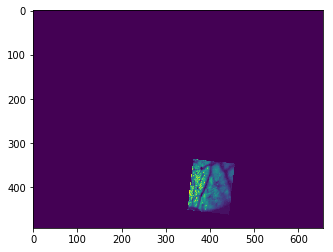

In [586]:
plt.figure()
plt.imshow(warped_fov2p)


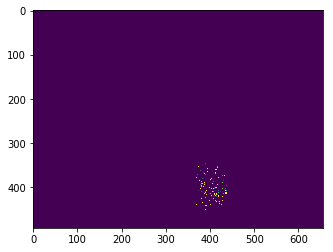

In [587]:
plt.figure()
plt.imshow(roi_img)